In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import time as time
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-13 23:02:54.114198: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Function Definitions

In [4]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    q_hats = []
    times = []
    errors = []
    upper_bounds = []
    lower_bounds = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            errors.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, errors, upper_bounds, lower_bounds

In [5]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    coverage = np.zeros(len(ci))
    upper_bounds = []
    lower_bounds = []
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, upper_bounds, lower_bounds

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

# Model Training

In [7]:
train = {1: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    3: {
    'start_time': "2011-04-19",
    'end_time': "2011-05-22"
},
    2: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    6: {
    'start_time': "2011-05-25",
    'end_time': "2011-06-13"

}}
test = {
    5: {
        'start_time': "2011-04-22",
        'end_time': "2011-06-01"
    }}
appliances = ["Refrigerator"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [10]:
model = seq2point_gaussian.seq2point()

In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

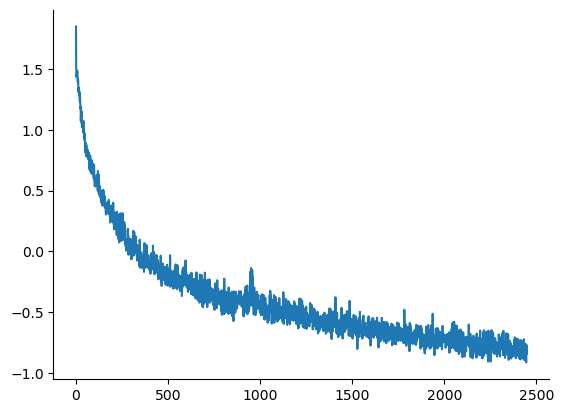

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 16.9 s'

# Before Calibration

##### Results on Calibration Set

In [14]:
%%capture cap
%%time
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [15]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [16]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 34.5440 MAE  : 16.4987 NLL : 3.7831


In [17]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.19 s'

##### Results on Training Set

In [18]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [19]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [20]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 33.7903 MAE  : 15.9411 NLL : 3.7376


##### Results on Test Set

In [21]:
# batch_size = 1024
# sequence_length = 99

# # Convolutional Layers
# conv_flops = [
#     30 * 10 * 10 * sequence_length * batch_size,
#     30 * 8 * 8 * sequence_length * batch_size,
#     40 * 6 * 6 * sequence_length * batch_size,
#     50 * 5 * 5 * sequence_length * batch_size,
#     50 * 5 * 5 * sequence_length * batch_size,
# ]

# # Dense Layers
# dense_flops = [
#     1024 * sequence_length * 1024 * (sequence_length - 1),
#     1024 * 21 * 1024 * (21 - 1),
# ]

# # Total FLOPS
# total_flops = sum(conv_flops) + sum(dense_flops)

# print(
#     f"FLOPS estimate for batch size {batch_size}: {total_flops / 1e9} GigaFLOPS")

In [22]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})


In [23]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [24]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 52.0835 MAE  : 31.0333 NLL : 5.7325


In [25]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 932 ms'

# After Calibration

### Conformal Prediction

##### Results on Calibration Set

In [26]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _, _, _, _ = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci)

In [27]:
initial_coverages_cal

array([0.        , 0.08627264, 0.17034081, 0.25077456, 0.32453528,
       0.40056005, 0.47026932, 0.56047428, 0.71031934, 0.88226885,
       1.        ])

In [28]:
flag = True
final_coverages_cal, q_hats, times, errors, uppers_cal, lowers_cal = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci, flag=flag)

In [29]:
final_coverages_cal

array([0.        , 0.10009533, 0.20001192, 0.30010724, 0.40008342,
       0.50011915, 0.60009533, 0.70013112, 0.80010724, 0.90014303,
       1.        ])

In [30]:
q_hats

[0,
 0.26568604,
 0.5775263,
 0.9624323,
 1.0492207,
 0.96184033,
 0.8386462,
 0.6739545,
 0.4486103,
 0.18881941,
 0]

In [31]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)

In [32]:
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.644184872508049 and ece error is 0.05856226113709537
Final ace error is 0.0008937865495681485 and ece error is 8.12533226880135e-05


##### Results on Training Set

In [33]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _, _, _ = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.08558094, 0.16971202, 0.25167826, 0.33076465,
       0.40466735, 0.47745782, 0.56897718, 0.71531284, 0.88536251,
       1.        ])

In [34]:
q_hats

[0,
 0.26568604,
 0.5775263,
 0.9624323,
 1.0492207,
 0.96184033,
 0.8386462,
 0.6739545,
 0.4486103,
 0.18881941,
 0]

In [35]:
flag = True
final_coverages_train, q_hats, uppers_train, lowers_train = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.10005959 0.19906655 0.30182722 0.40573984 0.50232375
 0.6039722  0.70430988 0.80379349 0.90432972 1.        ]


In [36]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)

In [37]:
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.6104864403605461 and ece error is 0.05549876730550419
Final ace error is 0.027289138734340662 and ece error is 0.0024808307940309693


##### Results on Test Set

In [38]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _, _, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.03383822, 0.06864325, 0.11053819, 0.15501128,
       0.20109572, 0.25845957, 0.32968095, 0.40638092, 0.51272964,
       1.        ])

In [39]:
q_hats

[0,
 0.26568604,
 0.5775263,
 0.9624323,
 1.0492207,
 0.96184033,
 0.8386462,
 0.6739545,
 0.4486103,
 0.18881941,
 0]

In [40]:
flag = True
final_coverages_test, q_hats, uppers_test, lowers_test = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.03899452 0.07992266 0.12665163 0.17595875 0.23009992
 0.29133096 0.36287466 0.43409604 0.51756364 1.        ]


In [41]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)

In [42]:
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 2.423622254282236 and ece error is 0.22032929584383965
Final ace error is 2.242507219314575 and ece error is 0.2038642926649614


##### Comparison of Results

In [43]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

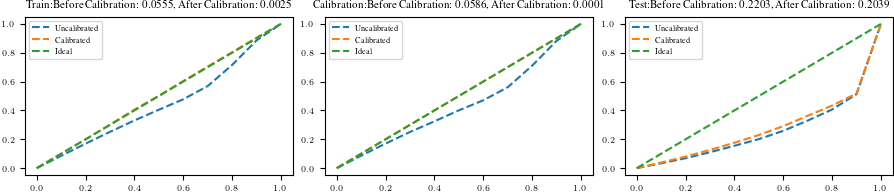

In [44]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')